In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt

import calendar
import pytz

from datetime import datetime, time, date, timedelta
from statsmodels.tsa.seasonal import STL
from scipy.stats import gaussian_kde, spearmanr
from scipy.integrate import quad
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')

In [2]:
df_wti = pd.read_csv(
    './data/backtestmarket/cl-15m.csv',
    sep=';', header=0,
    names=['date', 'time', 'open', 'high', 'low', 'close', 'volume']
)

df_wti['date'] = pd.to_datetime(df_wti['date'], format='%d/%m/%Y')
df_wti['date'] = df_wti['date'].dt.strftime('%m-%d-%Y')

df_wti['datetime'] = pd.to_datetime(df_wti['date'] + ' ' + df_wti['time'])

# convert to new york timezone
df_wti['datetime'] = df_wti['datetime'].dt.tz_localize('Etc/GMT+6')
ny_tz = pytz.timezone('America/New_York')
df_wti['datetime'] = df_wti['datetime'].dt.tz_convert(ny_tz)
df_wti['datetime'] = pd.to_datetime(df_wti['datetime'])

df_wti = df_wti[(df_wti['datetime'].dt.hour >= 9) & (df_wti['datetime'].dt.hour < 16)]
df_wti = df_wti[(df_wti['datetime'].dt.weekday != 5) & (df_wti['datetime'].dt.weekday != 6)]
df_wti.head()

,date,time,open,high,low,close,volume,datetime
54,04-02-2007,07:00:00,65.54,65.65,65.38,65.50,619,2007-04-02 09:00:00-04:00
55,04-02-2007,07:15:00,65.51,65.53,65.42,65.53,275,2007-04-02 09:15:00-04:00
56,04-02-2007,07:30:00,65.51,65.52,65.44,65.46,244,2007-04-02 09:30:00-04:00
57,04-02-2007,07:45:00,65.47,65.65,65.47,65.64,758,2007-04-02 09:45:00-04:00
58,04-02-2007,08:00:00,65.65,65.85,65.65,65.75,2164,2007-04-02 10:00:00-04:00


In [3]:
print(df_wti.head().drop(['date', 'time'], axis=1).to_markdown())

|    |   open |   high |   low |   close |   volume | datetime                  |
|---:|-------:|-------:|------:|--------:|---------:|:--------------------------|
| 54 |  65.54 |  65.65 | 65.38 |   65.5  |      619 | 2007-04-02 09:00:00-04:00 |
| 55 |  65.51 |  65.53 | 65.42 |   65.53 |      275 | 2007-04-02 09:15:00-04:00 |
| 56 |  65.51 |  65.52 | 65.44 |   65.46 |      244 | 2007-04-02 09:30:00-04:00 |
| 57 |  65.47 |  65.65 | 65.47 |   65.64 |      758 | 2007-04-02 09:45:00-04:00 |
| 58 |  65.65 |  65.85 | 65.65 |   65.75 |     2164 | 2007-04-02 10:00:00-04:00 |


# Volume Plots

- Check for a single year first, try 2018
- Limit time frame to 1000 - 1600
- Exclude weekends

In [4]:
df_year = df_wti[df_wti['datetime'].dt.year == 2018]
df_year.head(3)

,date,time,open,high,low,close,volume,datetime
255531,01-02-2018,08:00:00,60.32,60.50,60.32,60.41,14971,2018-01-02 09:00:00-05:00
255532,01-02-2018,08:15:00,60.41,60.45,60.34,60.41,7538,2018-01-02 09:15:00-05:00
255533,01-02-2018,08:30:00,60.42,60.53,60.16,60.25,24869,2018-01-02 09:30:00-05:00


<Axes: xlabel='volume', ylabel='Density'>

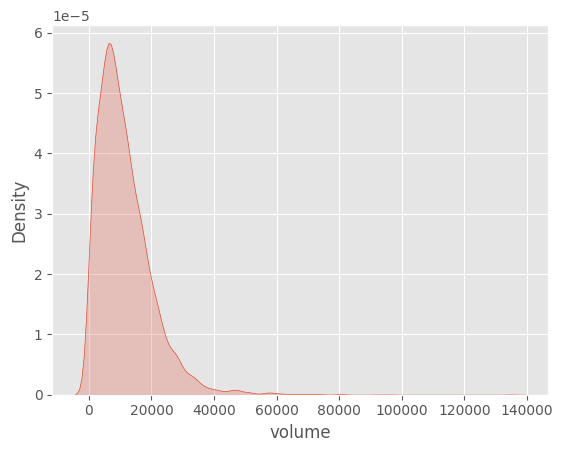

In [5]:
sns.kdeplot(df_year['volume'], shade=True)

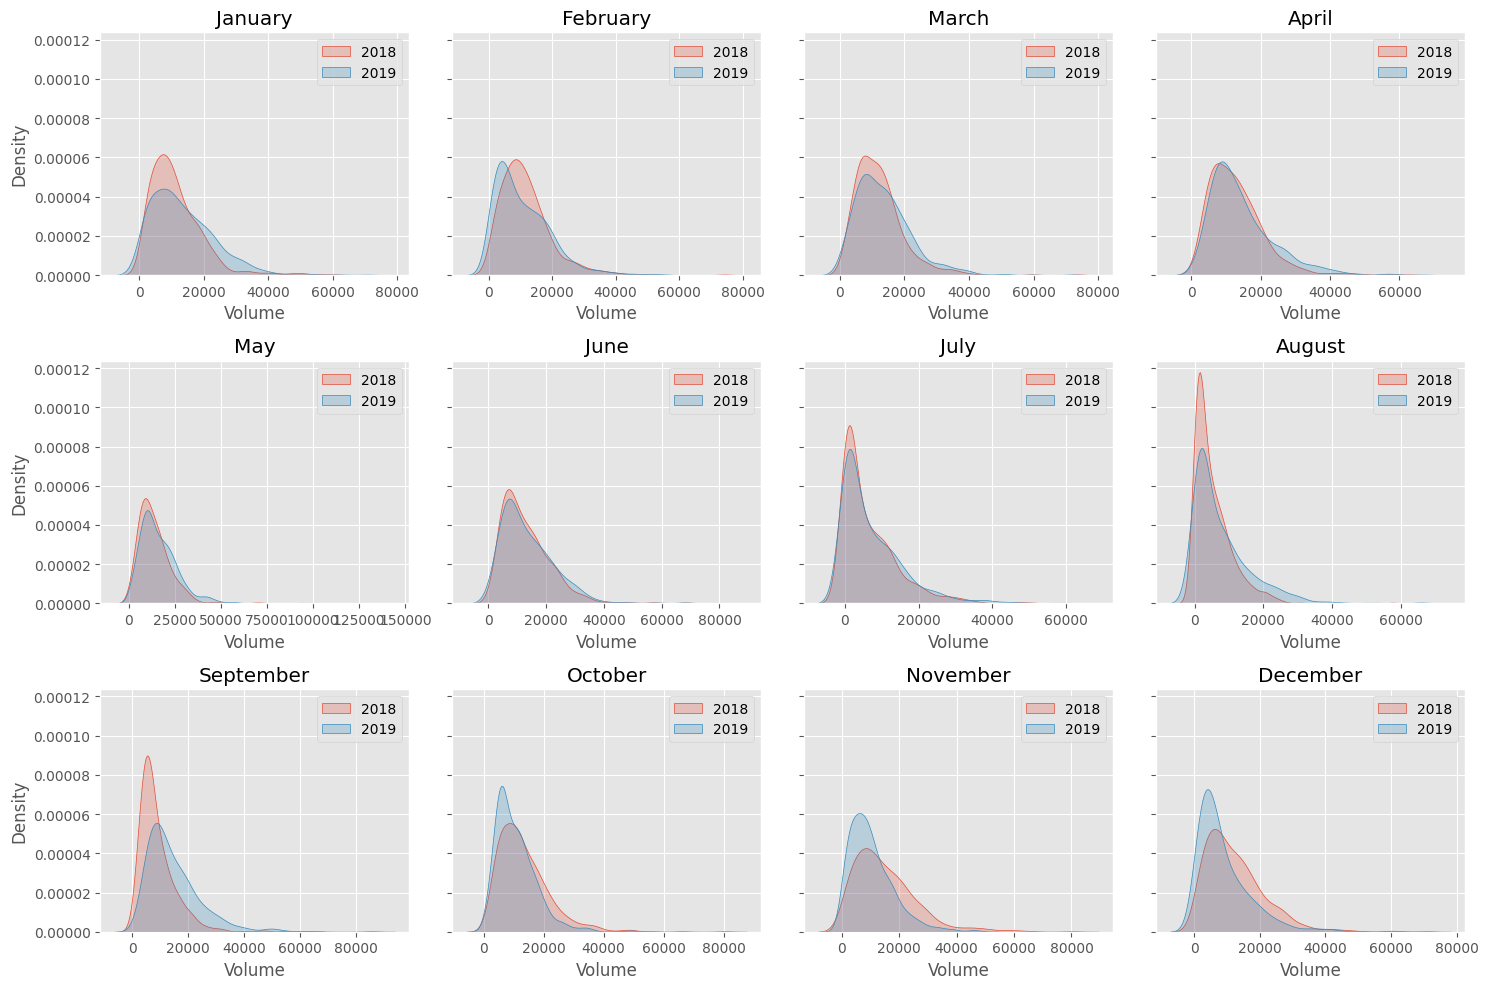

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10), sharey=True)

df_year2 = df_wti[df_wti['datetime'].dt.year == 2019]
df_year3 = df_wti[df_wti['datetime'].dt.year == 2020]

for i, month in enumerate(range(1, 13)):
    ax = axes[i // 4, i % 4]
    month_data = df_year[df_year['datetime'].dt.month == month]['volume']
    sns.kdeplot(month_data, shade=True, ax=ax, label='2018')
    ax.set_title(calendar.month_name[month])
    ax.set_xlabel('Volume')
    ax.set_ylabel('Density')

    month_data = df_year2[df_year2['datetime'].dt.month == month]['volume']
    sns.kdeplot(month_data, shade=True, ax=ax, label='2019')

    month_data = df_year3[df_year3['datetime'].dt.month == month]['volume']
    # sns.kdeplot(month_data, shade=True, ax=ax, label='2020')

    ax.legend()

plt.tight_layout()
plt.show()

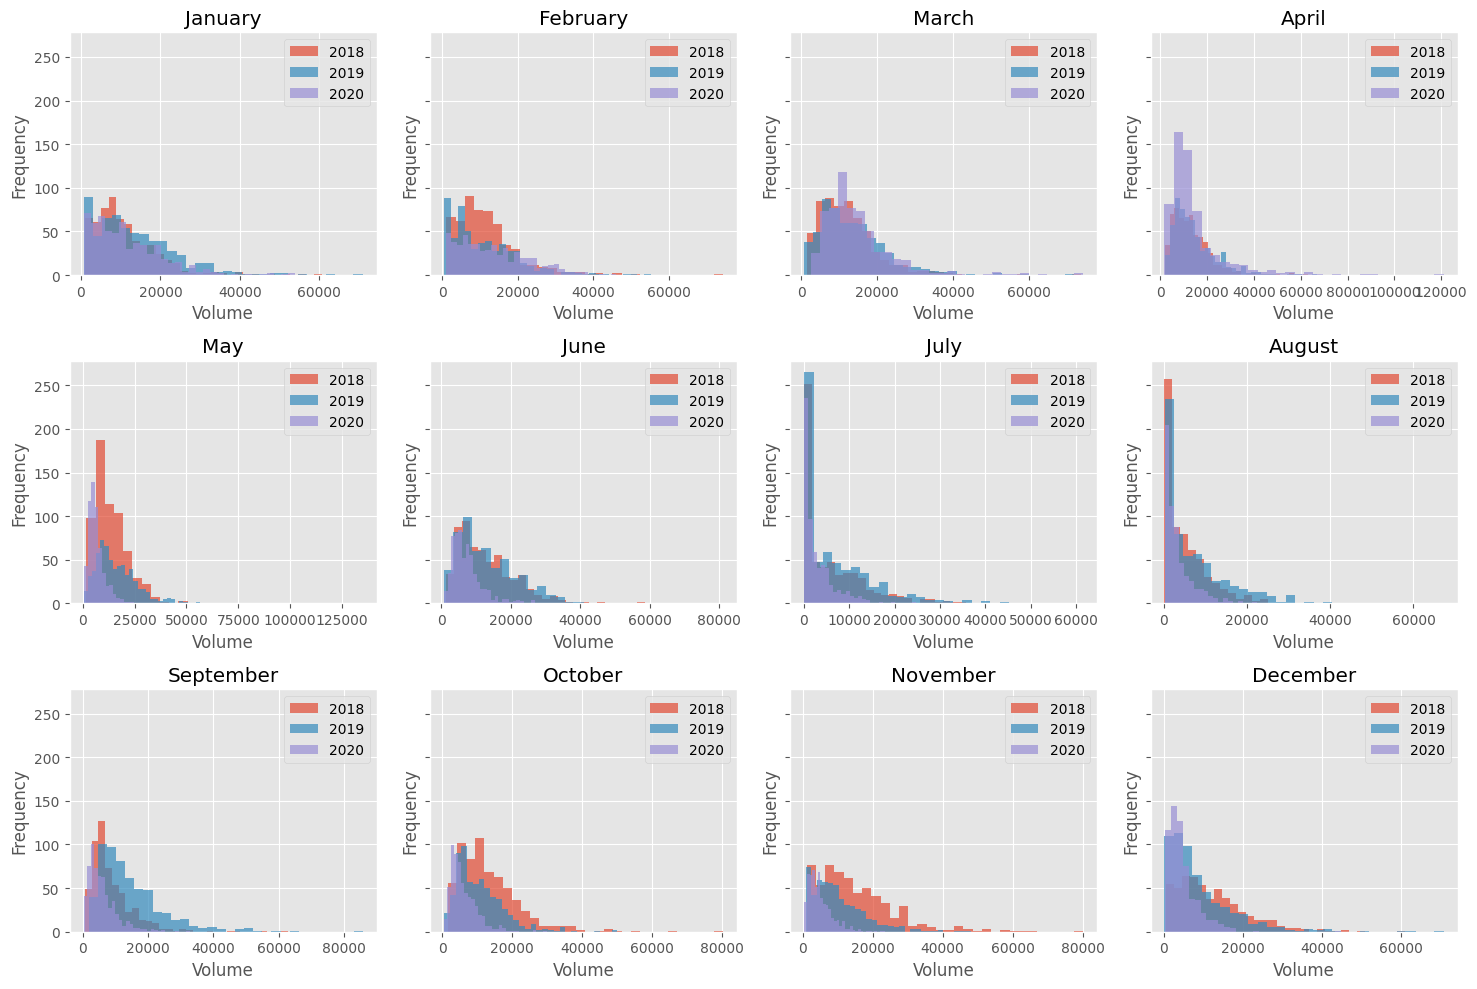

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10), sharey=True)

df_year2 = df_wti[df_wti['datetime'].dt.year == 2019]
df_year3 = df_wti[df_wti['datetime'].dt.year == 2020]

for i, month in enumerate(range(1, 13)):
    ax = axes[i // 4, i % 4]
    month_data = df_year[df_year['datetime'].dt.month == month]['volume']
    ax.set_title(calendar.month_name[month])
    ax.set_xlabel('Volume')
    ax.set_ylabel('Frequency')
    month_data.hist(ax=ax, alpha=0.7, label='2018', bins=30)

    month_data = df_year2[df_year2['datetime'].dt.month == month]['volume']
    month_data.hist(ax=ax, alpha=0.7, label='2019', bins=30)

    month_data = df_year3[df_year3['datetime'].dt.month == month]['volume']
    month_data.hist(ax=ax, alpha=0.7, label='2020', bins=30)

    ax.legend()

plt.tight_layout()
plt.show()

- Steady increase of trading volume over the years.
- Highest: January / February, Lowest: July / August
- Unimodal plot, centered around 10000
- Plot is skewed to right, there are few days with very high trading volume, possibility of extreme trading volume event

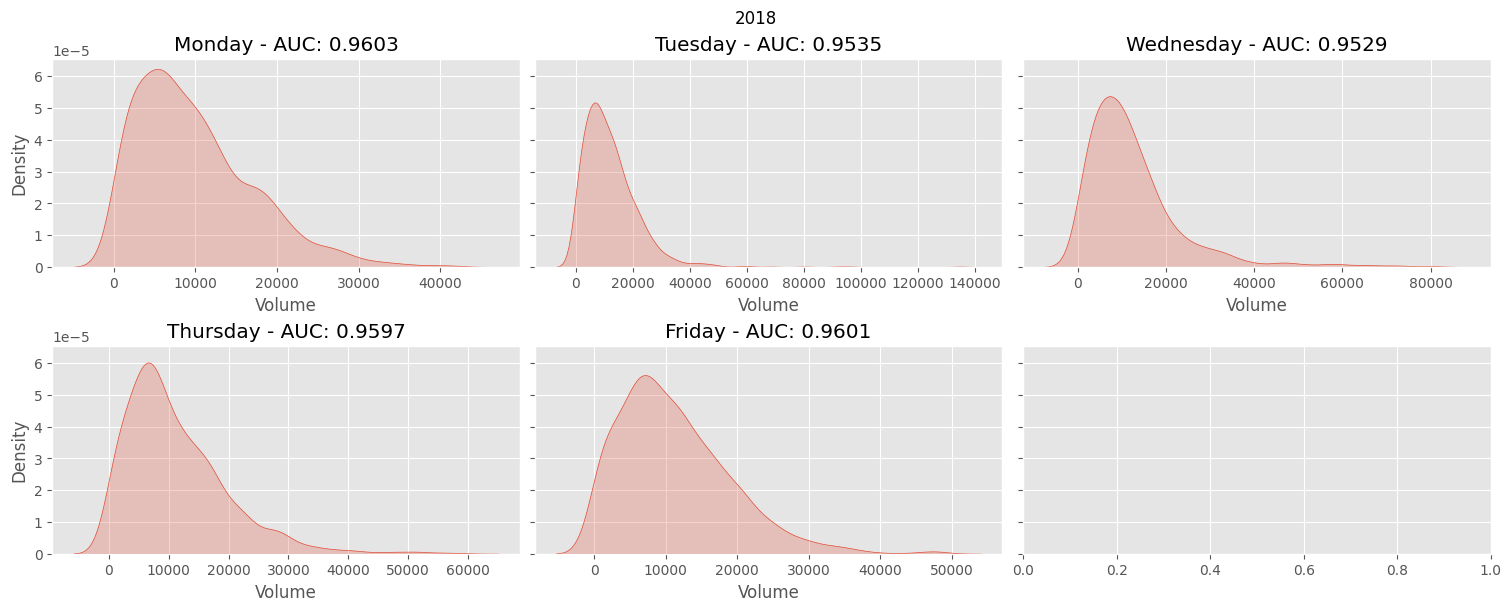

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 6), constrained_layout=True, sharey=True)

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
for i, day in enumerate(weekdays):
    day_data = df_year[df_year['datetime'].dt.day_name() == day]
    ax = axs[i // 3, i % 3]
    ax = sns.kdeplot(data=day_data['volume'], ax=ax, shade=True)
    kde = gaussian_kde(day_data['volume'])
    auc, _ = quad(kde.pdf, min(day_data['volume']), max(day_data['volume']))

    ax.set_title(f'{day} - AUC: {auc:.4f}')
    ax.set_xlabel('Volume')
    ax.set_ylabel('Density')

plt.suptitle('2018')
plt.show()

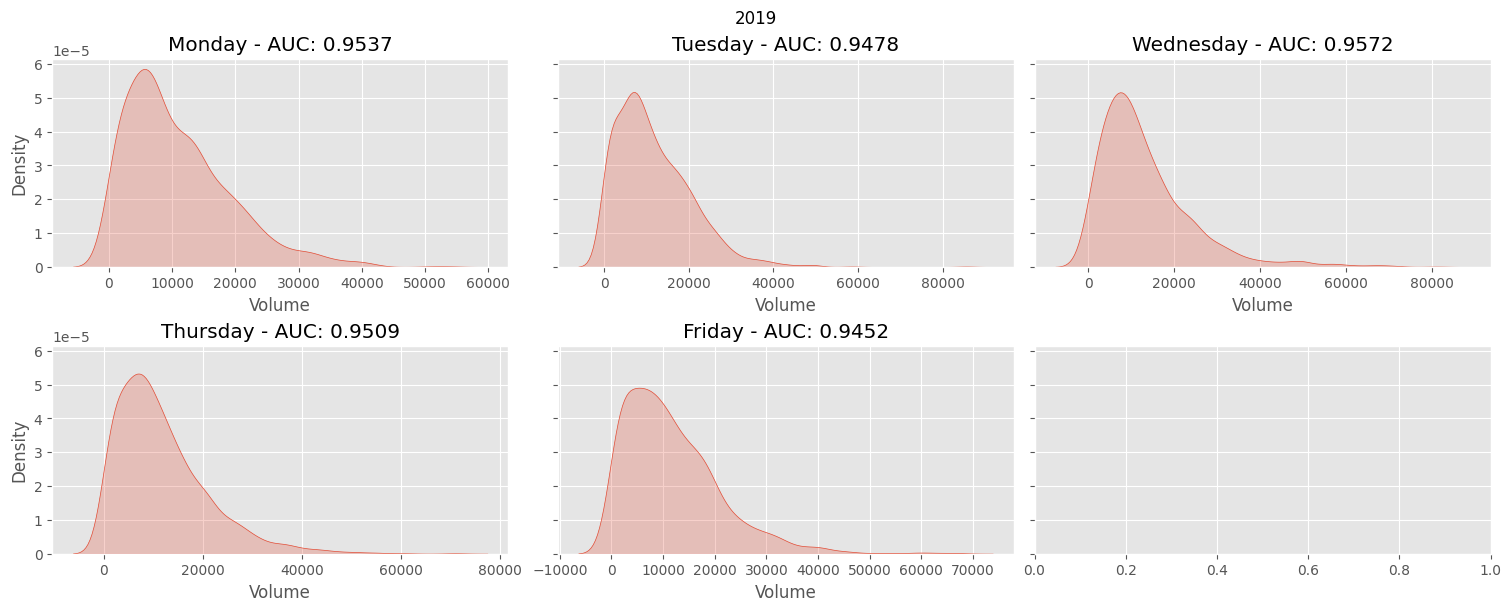

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 6), constrained_layout=True, sharey=True)

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
for i, day in enumerate(weekdays):
    day_data = df_year2[df_year2['datetime'].dt.day_name() == day]
    ax = axs[i // 3, i % 3]
    ax = sns.kdeplot(data=day_data['volume'], ax=ax, shade=True)
    kde = gaussian_kde(day_data['volume'])
    auc, _ = quad(kde.pdf, min(day_data['volume']), max(day_data['volume']))

    ax.set_title(f'{day} - AUC: {auc:.4f}')
    ax.set_xlabel('Volume')
    ax.set_ylabel('Density')
plt.suptitle('2019')
plt.show()

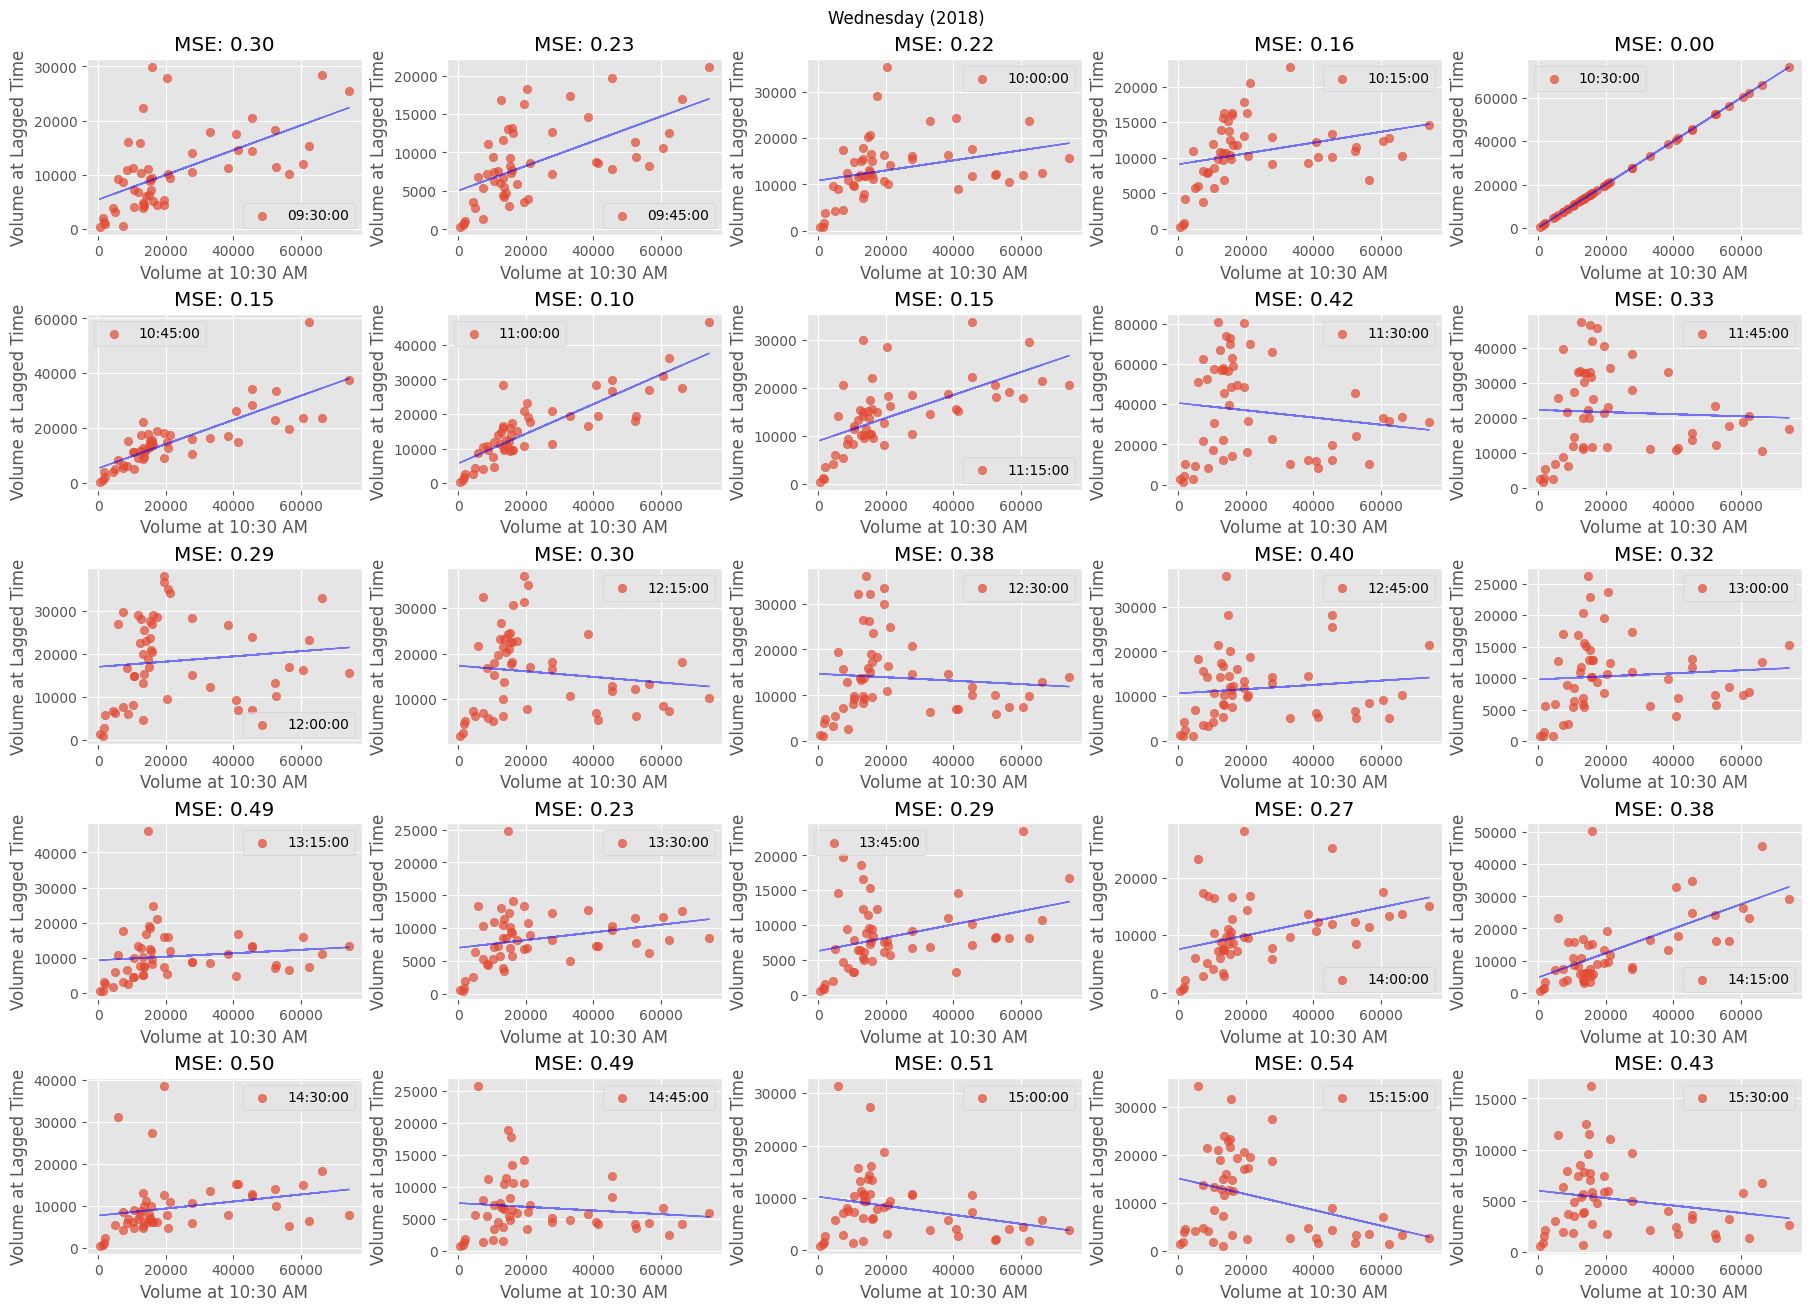

In [26]:
df_wednesday = df_year[df_year['datetime'].dt.day_name() == 'Wednesday']
df_1030 = df_wednesday[df_wednesday['datetime'].dt.time == pd.to_datetime('10:30:00').time()]

# Filter data for volumes at other specific times until 4 PM
start_time = time(9, 30)
end_time = time(15, 30)

# Initialize a list to store time points
time_points = []

# Create time points at 15-minute intervals from start to end
current_time = datetime.combine(date.today(), start_time)
while current_time.time() <= end_time:
    time_points.append(current_time.time().strftime('%H:%M:%S'))
    current_time += timedelta(minutes=15)

lag_data = []
for time_point in time_points:
    df_at_time = df_wednesday[df_wednesday['datetime'].dt.time == pd.to_datetime(time_point).time()]
    lag_data.append(df_at_time)

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(18, 13), constrained_layout=True)
for i, df_lagged in enumerate(lag_data):
    ax = axs[i // 5, i % 5]

    volume_1030 = df_1030[df_1030['datetime'].dt.date.isin(df_lagged['datetime'].dt.date)]['volume']
    ax.scatter(volume_1030, df_lagged['volume'], alpha=0.7, label=f'{time_points[i]}')

    model = LinearRegression()
    X = np.array(volume_1030).reshape(-1, 1)
    y = np.array(df_lagged['volume'])
    model.fit(X, y)
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred) / (np.mean(y)**2) 
    ax.plot(X, y_pred, color='blue', linewidth=1, alpha=0.5)

    ax.set_title(f'MSE: {mse:.2f}')
    ax.set_xlabel('Volume at 10:30 AM')
    ax.set_ylabel('Volume at Lagged Time')
    ax.legend()

plt.suptitle('Wednesday (2018)')
plt.show()

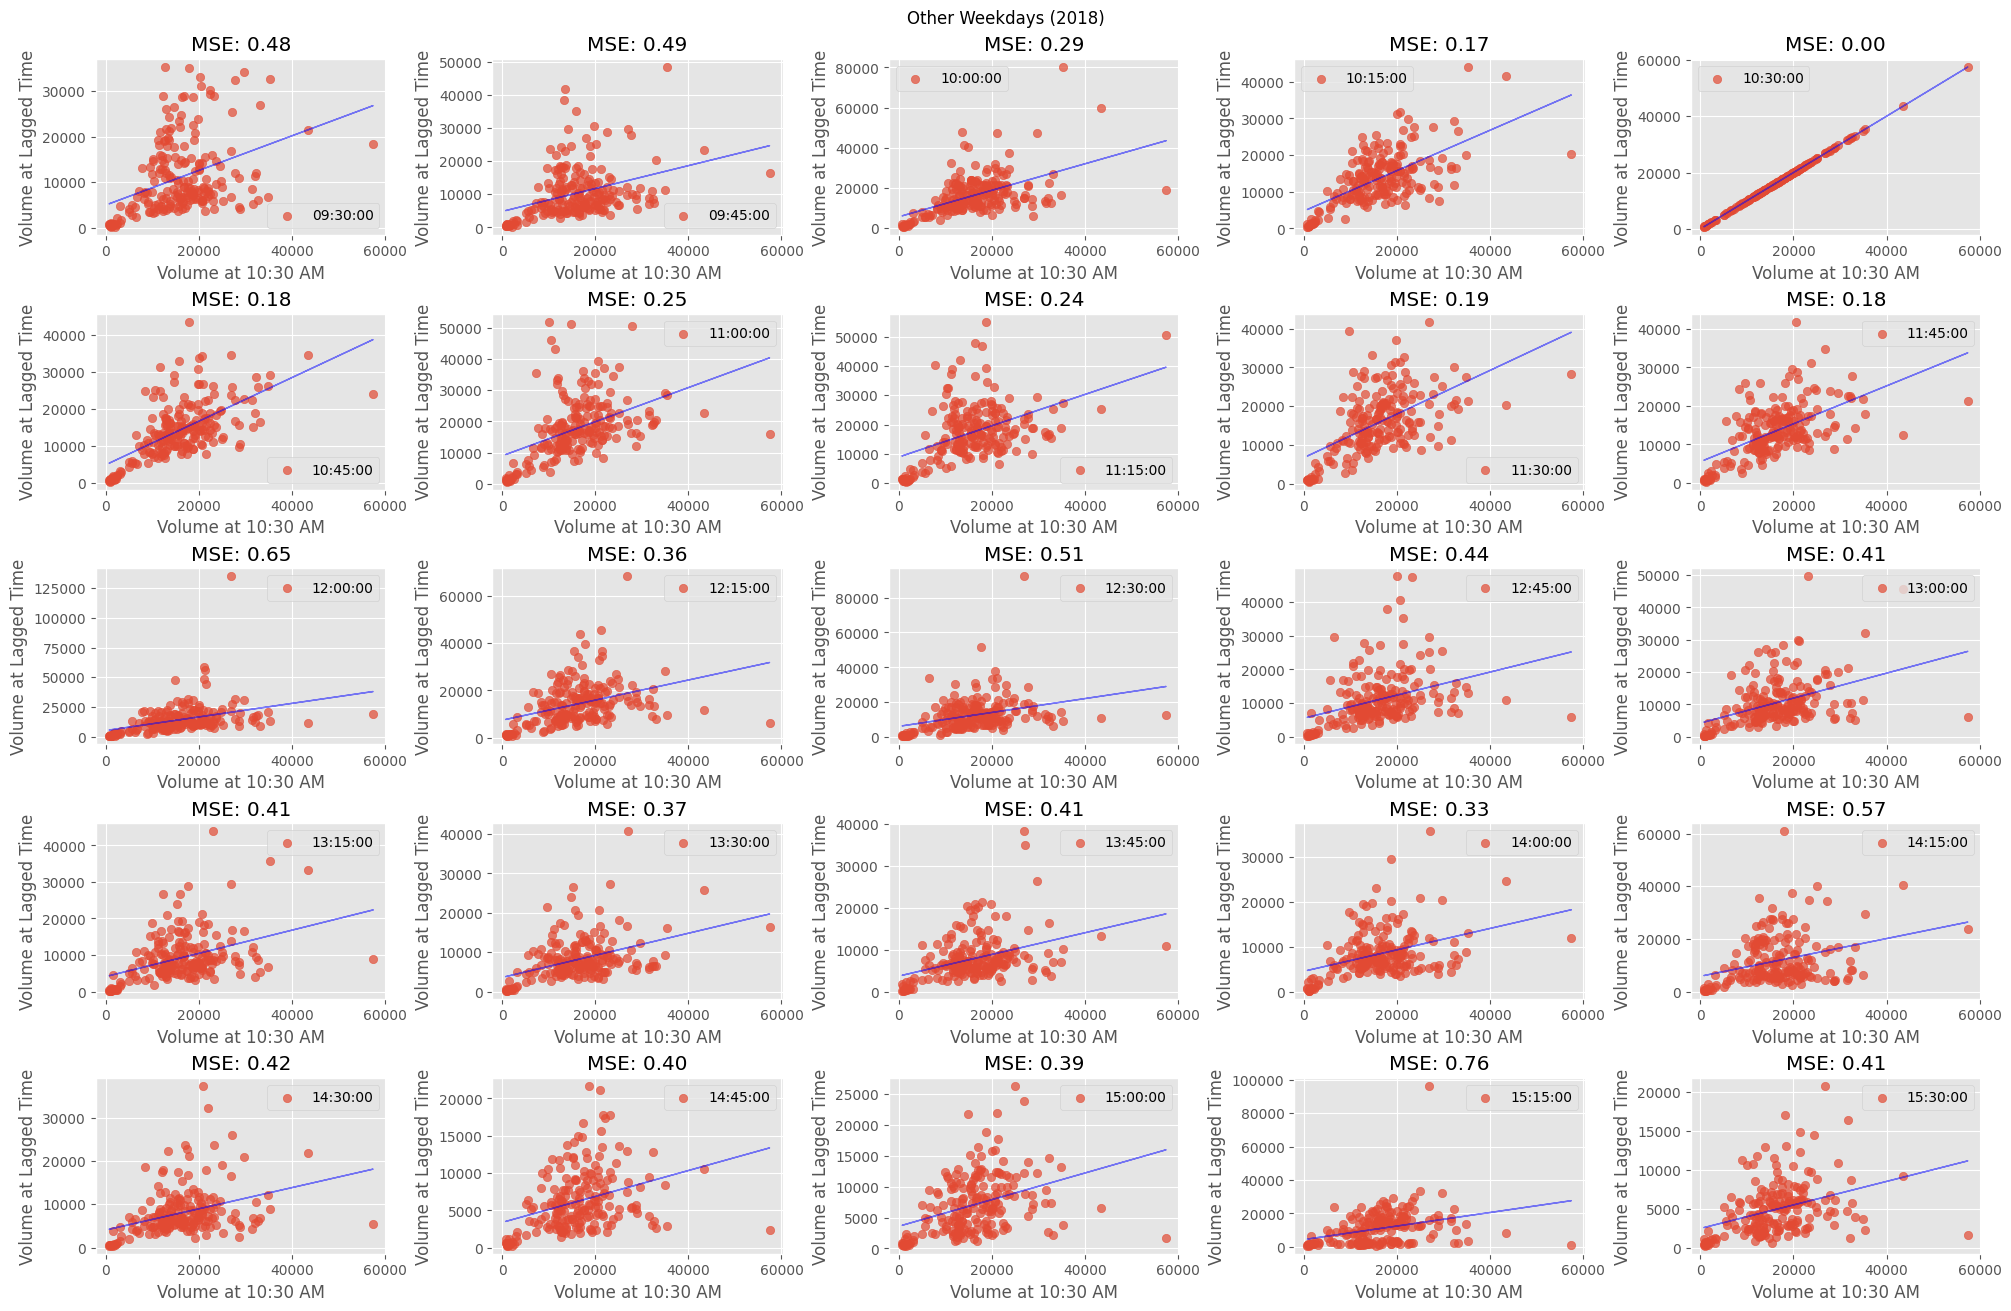

In [27]:
df_other_days = df_year[df_year['datetime'].dt.day_name() != 'Wednesday']
df_1030 = df_other_days[df_other_days['datetime'].dt.time == pd.to_datetime('10:30:00').time()]

# Filter data for volumes at other specific times until 4 PM
start_time = time(9, 30)
end_time = time(15, 30)

# Initialize a list to store time points
time_points = []

# Create time points at 15-minute intervals from start to end
current_time = datetime.combine(date.today(), start_time)
while current_time.time() <= end_time:
    time_points.append(current_time.time().strftime('%H:%M:%S'))
    current_time += timedelta(minutes=15)

lag_data = []
for time_point in time_points:
    df_at_time = df_other_days[df_other_days['datetime'].dt.time == pd.to_datetime(time_point).time()]
    lag_data.append(df_at_time)

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 13), constrained_layout=True)
for i, df_lagged in enumerate(lag_data):
    ax = axs[i // 5, i % 5]

    volume_1030 = df_1030[df_1030['datetime'].dt.date.isin(df_lagged['datetime'].dt.date)]['volume']
    ax.scatter(volume_1030, df_lagged['volume'], alpha=0.7, label=f'{time_points[i]}')

    model = LinearRegression()
    X = np.array(volume_1030).reshape(-1, 1)
    y = np.array(df_lagged['volume'])
    model.fit(X, y)
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred) / (np.mean(y)**2) 
    ax.plot(X, y_pred, color='blue', linewidth=1, alpha=0.5)

    ax.set_title(f'MSE: {mse:.2f}')

    ax.set_xlabel('Volume at 10:30 AM')
    ax.set_ylabel('Volume at Lagged Time')
    ax.legend()

plt.suptitle('Other Weekdays (2018)')
plt.show()

50% of volume falls within 5219.0 and 15597.0


/tmp/ipykernel_44895/1502709306.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['Z_score'] = (df_year['volume'] - mean) / std_dev
/tmp/ipykernel_44895/1502709306.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers.loc[:, 'weekday'] = outliers['datetime'].dt.day_name().values


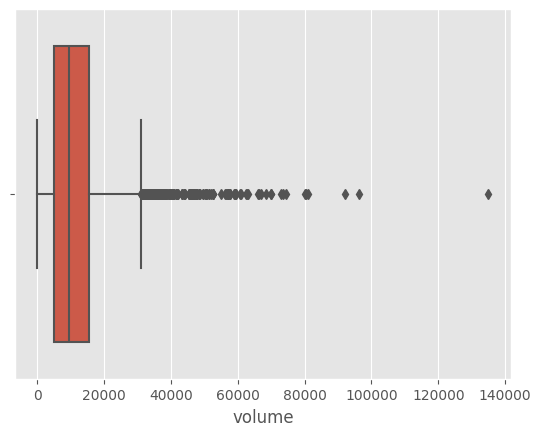

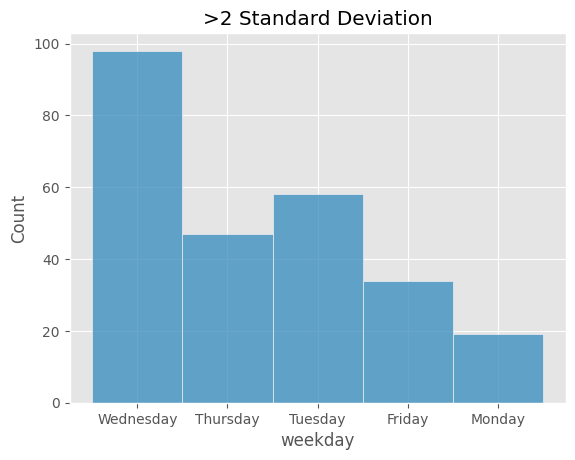

In [12]:
mean = df_year['volume'].mean()
std_dev = df_year['volume'].std()
df_year['Z_score'] = (df_year['volume'] - mean) / std_dev

threshold = 2
outliers = df_year[df_year['Z_score'] > threshold]
outliers.loc[:, 'weekday'] = outliers['datetime'].dt.day_name().values

Q1 = df_year['volume'].quantile(0.25)
Q3 = df_year['volume'].quantile(0.75)
print(f'50% of volume falls within {Q1} and {Q3}')

sns.boxplot(x=df_year['volume'])
plt.show()

sns.histplot(outliers['weekday']).set(title=f'>{threshold} Standard Deviation')
plt.show()

# Decomposition

/tmp/ipykernel_44895/2675911637.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_tmp = df_year.resample('H', on='datetime').mean()


[Text(0.5, 1.0, '2018 Volume (average by hour)')]

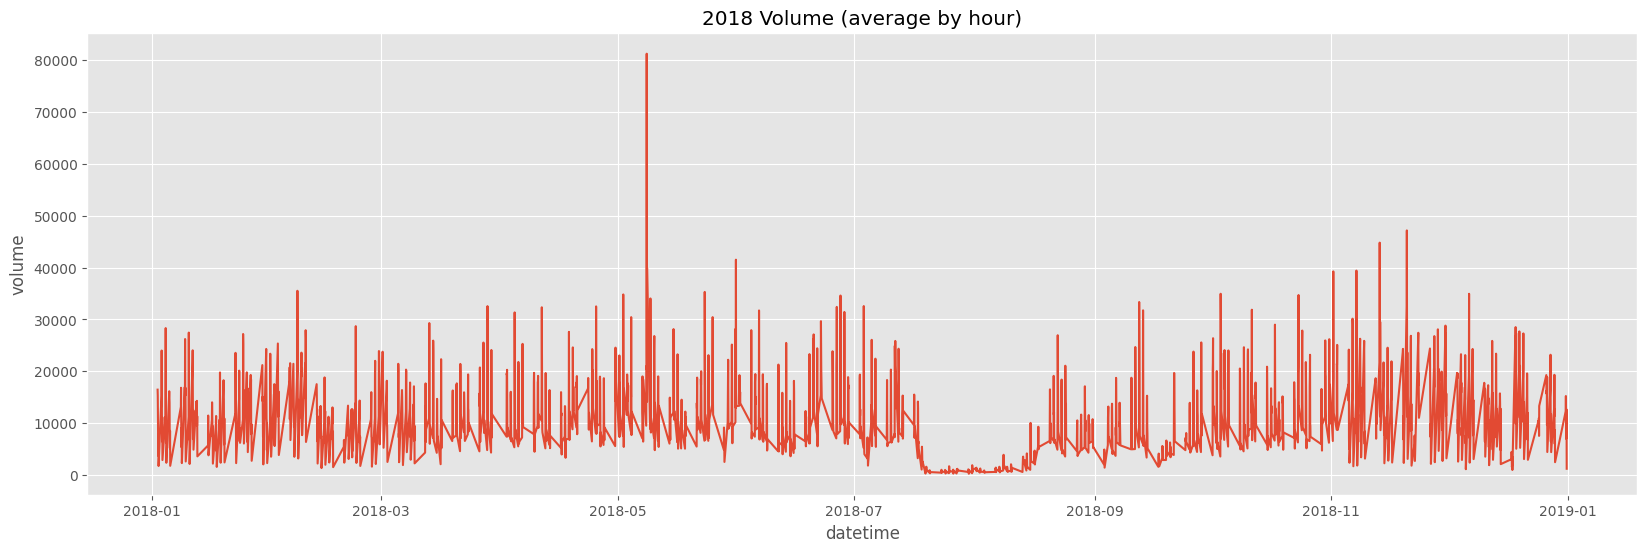

In [13]:
df_tmp = df_year.resample('H', on='datetime').mean()
df_tmp = df_tmp.dropna(axis=0).sort_values('datetime')

fig, ax = plt.subplots(figsize=(20, 6))
sns.lineplot(data=df_tmp, y='volume', x='datetime', ax=ax).set(title='2018 Volume (average by hour)')

/tmp/ipykernel_44895/3624375483.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_tmp = df_year2.resample('H', on='datetime').mean()


[Text(0.5, 1.0, '2018 Volume (average by hour)')]

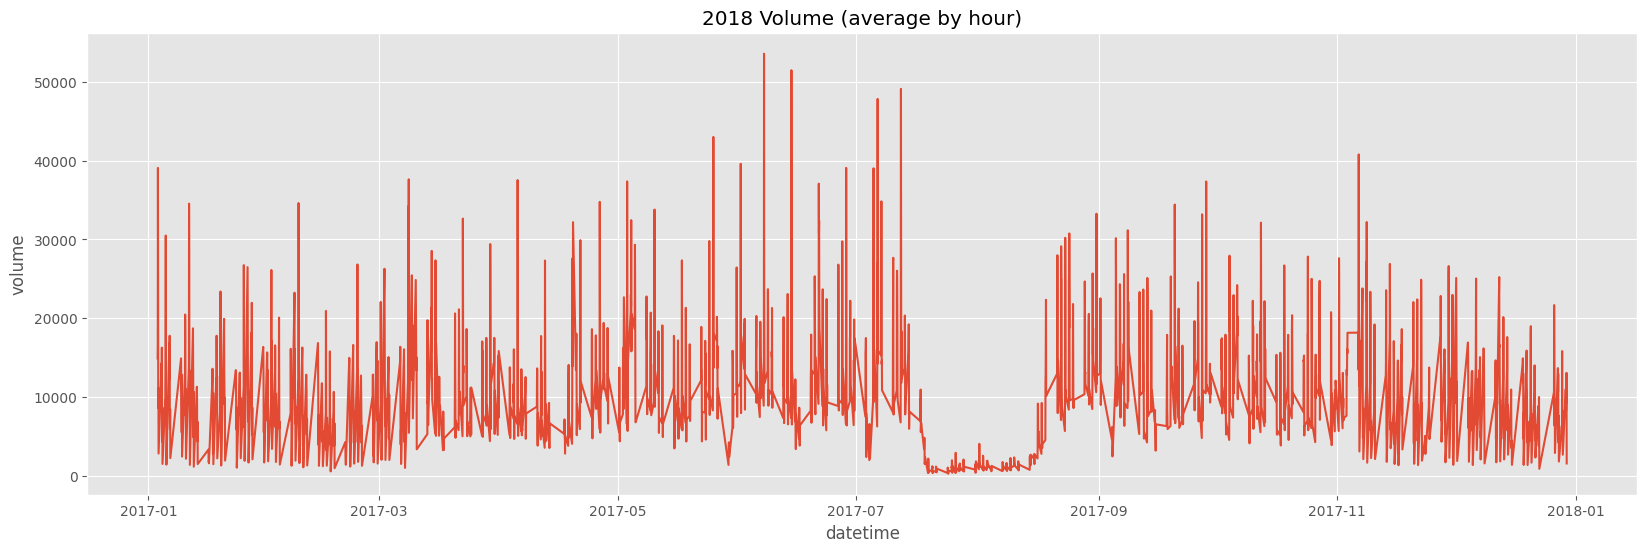

In [14]:
df_year2 = df_wti[df_wti['datetime'].dt.year == 2017]
df_tmp = df_year2.resample('H', on='datetime').mean()
df_tmp = df_tmp.dropna(axis=0).sort_values('datetime')

fig, ax = plt.subplots(figsize=(20, 6))
sns.lineplot(data=df_tmp, y='volume', x='datetime', ax=ax).set(title='2018 Volume (average by hour)')

[*********************100%%**********************]  1 of 1 completed


/tmp/ipykernel_44895/2629072168.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_wti_day = df_year.resample('D', on='datetime').sum()


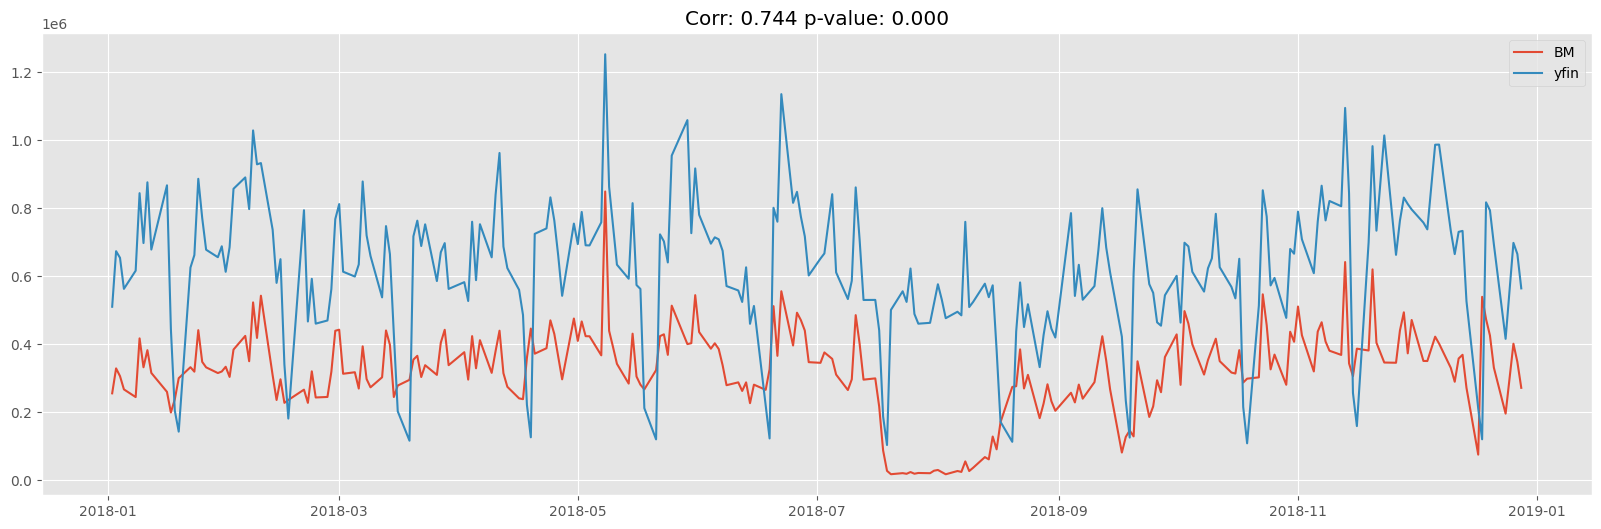

In [15]:
df_yfin = yf.download('CL=F', interval='1d', start='2018-01-01', end='2018-12-31')
df_yfin['Date'] = df_yfin.index

df_wti_day = df_year.resample('D', on='datetime').sum()
df_wti_day = df_wti_day.dropna(axis=0).sort_values('datetime')
df_wti_day = df_wti_day.reset_index(drop=False)
df_wti_day['datetime2'] = df_wti_day['datetime'].dt.strftime('%Y%m%d')
df_yfin['Date'] = df_yfin['Date'].dt.strftime('%Y%m%d')
df_wti_day = df_wti_day[df_wti_day['datetime2'].isin(df_yfin['Date'])]

corr, p_value = spearmanr(df_wti_day['volume'], df_yfin['Volume'])

plt.figure(figsize=(20, 6))
plt.plot(df_wti_day['datetime'], df_wti_day['volume'], label='BM')
plt.plot(df_wti_day['datetime'], df_yfin['Volume'], label='yfin')
plt.title(f'Corr: {corr:.3f} p-value: {p_value:.3f}')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed


/tmp/ipykernel_44895/3731389198.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_wti_day = df_year.resample('D', on='datetime').sum()


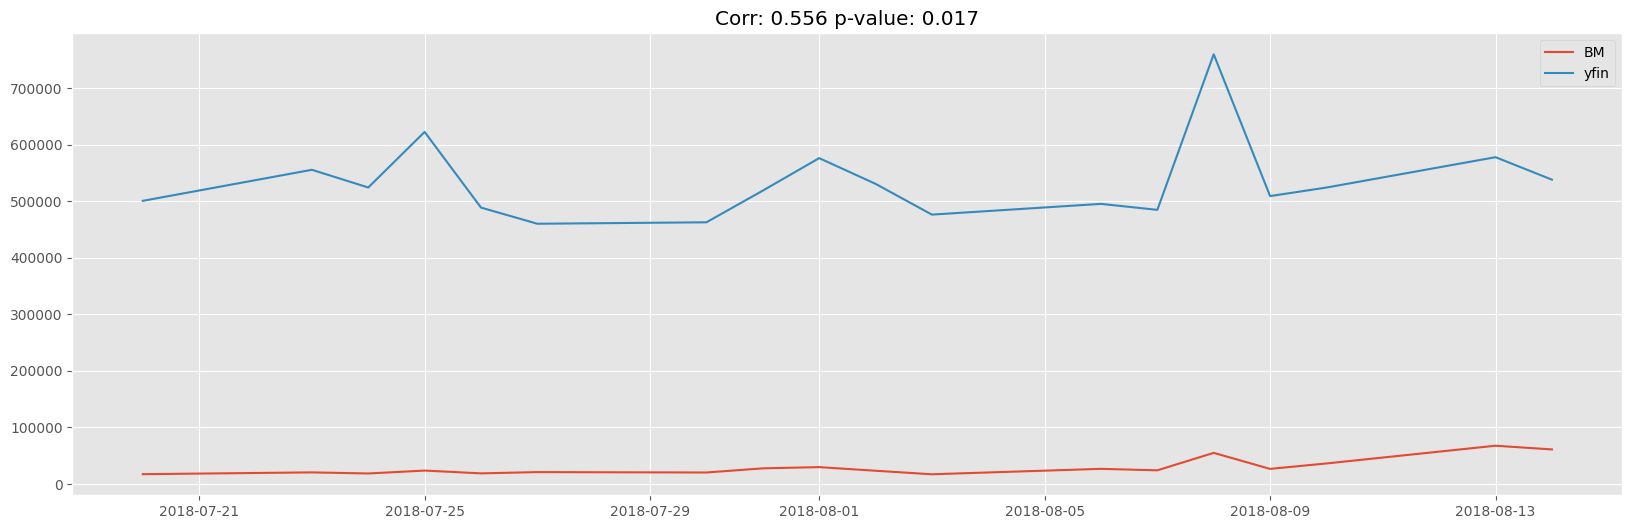

In [18]:
df_yfin = yf.download('CL=F', interval='1d', start='2018-07-20', end='2018-8-15')
df_yfin['Date'] = df_yfin.index

df_wti_day = df_year.resample('D', on='datetime').sum()
df_wti_day = df_wti_day.dropna(axis=0).sort_values('datetime')
df_wti_day = df_wti_day.reset_index(drop=False)
# df_wti_day = df_wti_day[(df_wti_day['datetime'].dt.month == 7) | (df_wti_day['datetime'].dt.month == 8)]
df_wti_day['datetime2'] = df_wti_day['datetime'].dt.strftime('%Y%m%d')
df_yfin['Date'] = df_yfin['Date'].dt.strftime('%Y%m%d')
df_wti_day = df_wti_day[df_wti_day['datetime2'].isin(df_yfin['Date'])]

corr, p_value = spearmanr(df_wti_day['volume'], df_yfin['Volume'])

plt.figure(figsize=(20, 6))
plt.plot(df_wti_day['datetime'], df_wti_day['volume'], label='BM')
plt.plot(df_wti_day['datetime'], df_yfin['Volume'], label='yfin')
plt.title(f'Corr: {corr:.3f} p-value: {p_value:.3f}')
plt.legend()
plt.show()